## 字詞分類

**Author:** 黃天原  
本周課程為「文件分類」，主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用決策樹、logistic regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「中文」的文件分類，使用聯合新聞網的三個版別文章做示範。

## 分析目標
+ 資料內容：
    + 資料來源：聯合新聞網
    + 版別：股市、運動、兩岸  

* 分析主題：將聯合新聞網三個版別的文章合起來，訓練模型能預測新聞版別，再用分類模型進行文件的版別分類。

* 以下為教學目標：
    1. 如何將以數字向量代表一篇文章？
        * `CountVectorizer`
        * `TfidfVectorizer`
    2. 基本的分類模型流程，包含以下三步驟：
        * 前處理 (preprocess)
        * 建模 (train model)
        * 評估與預測 (evaluation and predict)
    3. cross validation
    4. 不同分類器的效果
    5. 可解釋的可視化模型結果
    6. 預測其他家新聞文章的版別

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- **sklearn**: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具

In [1]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

In [2]:
from matplotlib import font_manager

font_set = {f.name for f in font_manager.fontManager.ttflist}
for f in font_set:
    print(f)

Z003
LakkiReddy
KacstLetter
Gidugu
Liberation Serif
Lohit Assamese
Syamala Ramana
Karumbi
KacstBook
Tlwg Typo
Standard Symbols PS
Sawasdee
C059
STIXSizeThreeSym
Saab
Dhurjati
Pothana2000
TenaliRamakrishna
P052
DejaVu Sans Display
Lohit Malayalam
Navilu
Lohit Kannada
D050000L
STIXSizeOneSym
Lohit Gujarati
Samyak Tamil
cmmi10
Gubbi
Sarai
padmaa
padmaa-Bold.1.1
DejaVu Serif
Liberation Mono
Kalapi
KacstQurn
Tlwg Typist
Nimbus Roman
STIXGeneral
Noto Sans CJK JP
Uroob
Tlwg Typewriter
KacstOffice
Kinnari
cmex10
Keraleeyam
Tibetan Machine Uni
KacstFarsi
ori1Uni
Mitra 
Mandali
Ubuntu Condensed
Samyak Devanagari
Khmer OS
KacstDecorative
NATS
Purisa
Timmana
Liberation Sans Narrow
STIXSizeFourSym
FreeSerif
Manjari
Mukti
Padauk
OpenSymbol
Norasi
mry_KacstQurn
Suravaram
Lohit Devanagari
Likhan
Ponnala
Noto Mono
Potti Sreeramulu
Padauk Book
Peddana
Rasa
Abyssinica SIL
KacstTitle
Dyuthi
LKLUG
Nimbus Sans Narrow
Droid Sans Fallback
STIXSizeFiveSym
KacstOne
Sree Krushnadevaraya
DejaVu Sans
Waree
Mallann

Text(0.5, 1.0, '聲量圖')

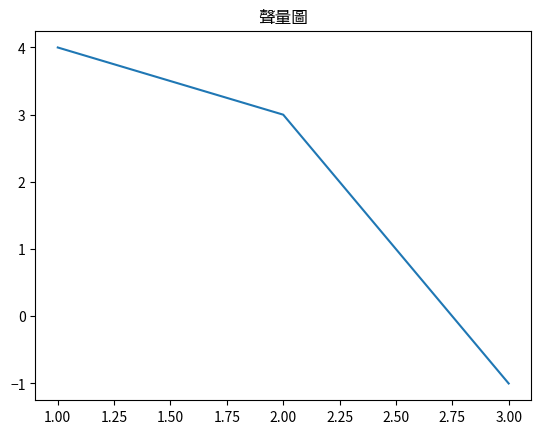

In [3]:
# matplotlib.rcParams['font.family'] = ['Noto Sans Mono CJK TC', 'sans-serif']
plt.rcParams["font.sans-serif"] = ["Noto Sans CJK JP"]
plt.plot((1, 2, 3), (4, 3, -1))
plt.title("聲量圖")

## 2. 文字前處理
`udn_news_03.csv`裡面包含了要分析的 udn 新聞資料。首先我們先看文集的基本資料，並做文集前處理。

In [4]:
udn = pd.read_csv("raw_data/udn_news_03.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,經典賽／夠經典！大聯盟拍賣網站 潘威倫球衣出價最高,2023-03-01 11:46:00,運動,經典賽,https://udn.com/news/story/10785/7001130,世界棒球經典賽將在3月8日開打，大聯盟也在拍賣網站推出歷屆經典賽實戰用品供球迷競標，目前所有...,UDN
1,2,經典賽／神秘巴拿馬30人名單揭曉 5大聯盟+1前中職洋投,2023-03-01 12:09:00,運動,經典賽,https://udn.com/news/story/10785/7001237,世界棒球經典賽將在3月8日開打，中華隊首戰對手巴拿馬隊今天公布最終30人名單，其中有5名現役...,UDN
2,3,經典賽／大谷翔平發文宣告與日本隊合體 何時出賽還不確定,2023-03-01 17:21:00,運動,經典賽,https://udn.com/news/story/10785/7002171,世界棒球經典賽將在下周3月8日開打，將代表日本出征的大谷翔平今天進行春訓初登板，賽後馬上啟程...,UDN


In [5]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")


number of posts: 5985
date range: ('2023-03-01 07:00:00', '2023-03-31 23:39:00')
category: 
股市    2211
運動    2009
兩岸    1765
Name: artCatagory, dtype: int64


+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字）

### 2.1 清理

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [6]:
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,經典賽夠經典大聯盟拍賣網站潘威倫球衣出價最高,2023-03-01 11:46:00,運動,經典賽,https://udn.com/news/story/10785/7001130,世界棒球經典賽將在月日開打大聯盟也在拍賣網站推出歷屆經典賽實戰用品供球迷競標目前所有拍賣物品...,UDN
1,2,經典賽神秘巴拿馬人名單揭曉大聯盟前中職洋投,2023-03-01 12:09:00,運動,經典賽,https://udn.com/news/story/10785/7001237,世界棒球經典賽將在月日開打中華隊首戰對手巴拿馬隊今天公布最終人名單其中有名現役大聯盟球員還有...,UDN
2,3,經典賽大谷翔平發文宣告與日本隊合體何時出賽還不確定,2023-03-01 17:21:00,運動,經典賽,https://udn.com/news/story/10785/7002171,世界棒球經典賽將在下周月日開打將代表日本出征的大谷翔平今天進行春訓初登板賽後馬上啟程返日準備...,UDN


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。

In [7]:
# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory
0,經典賽夠經典大聯盟拍賣網站潘威倫球衣出價最高世界棒球經典賽將在月日開打大聯盟也在拍賣網站推出...,https://udn.com/news/story/10785/7001130,運動
1,經典賽神秘巴拿馬人名單揭曉大聯盟前中職洋投世界棒球經典賽將在月日開打中華隊首戰對手巴拿馬隊今...,https://udn.com/news/story/10785/7001237,運動
2,經典賽大谷翔平發文宣告與日本隊合體何時出賽還不確定世界棒球經典賽將在下周月日開打將代表日本出...,https://udn.com/news/story/10785/7002171,運動
3,經典賽鄧愷威搭上飛機了日會合中華隊日登板旅美投手鄧愷威加入中華隊的時間出爐總教練林岳平今天表...,https://udn.com/news/story/10785/7002266,運動
4,經典賽古巴隊會藏中華隊餅總保持戒心古巴隊昨天以擊敗味全龍拿下來台後熱身賽首勝這三場比賽中華隊...,https://udn.com/news/story/10785/7002313,運動


In [8]:
# 看看有幾篇文章
print(f"total docs: {udn.shape[0]}")


total docs: 5985


### 2.2 斷詞

In [9]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [10]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [11]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

Building prefix dict from /home/evan19983314/SMA/SMA_2023S/week11_classification/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.uf86e896fa1a801cc442cbab0bb7b6f1d.cache
Loading model cost 1.696 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,經典賽夠經典大聯盟拍賣網站潘威倫球衣出價最高世界棒球經典賽將在月日開打大聯盟也在拍賣網站推出...,https://udn.com/news/story/10785/7001130,運動,經典 賽夠 經典 聯盟 拍賣 網站 潘威倫 球衣 出價 最高 世界 棒球 經典 賽將 開打 ...
1,經典賽神秘巴拿馬人名單揭曉大聯盟前中職洋投世界棒球經典賽將在月日開打中華隊首戰對手巴拿馬隊今...,https://udn.com/news/story/10785/7001237,運動,經典 神秘 巴拿馬人 名單 揭曉 聯盟 中職 洋投 世界 棒球 經典 賽將 開打 中華隊 首...
2,經典賽大谷翔平發文宣告與日本隊合體何時出賽還不確定世界棒球經典賽將在下周月日開打將代表日本出...,https://udn.com/news/story/10785/7002171,運動,經典 大谷 翔平 發文 宣告 日本隊 合體 出賽 還不 確定 世界 棒球 經典 賽將 下周 ...
3,經典賽鄧愷威搭上飛機了日會合中華隊日登板旅美投手鄧愷威加入中華隊的時間出爐總教練林岳平今天表...,https://udn.com/news/story/10785/7002266,運動,經典 鄧愷威 飛機 會合 中華隊 日登板 旅美 投手 鄧愷威 加入 中華隊 時間 出爐 總教...
4,經典賽古巴隊會藏中華隊餅總保持戒心古巴隊昨天以擊敗味全龍拿下來台後熱身賽首勝這三場比賽中華隊...,https://udn.com/news/story/10785/7002313,運動,經典 古巴隊 會藏 中華隊 餅總 保持 戒心 古巴隊 昨天 擊敗 味全 下來 熱身賽 首勝 ...


### 2.3 資料集基本檢視

檢視資料內容

In [12]:
print(f"total posts: {len(udn['artUrl'].unique())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")


total posts: 5985
category: 
股市    2211
運動    2009
兩岸    1765
Name: artCatagory, dtype: int64


## 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標（每個句子所屬的書名id）。

In [13]:
data = udn
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

1576    杜拜 網賽 克維奇 輸給 梅德維夫 今年 連勝 句點 塞爾維亞 網球 名將 克維奇 今天 杜...
3944    宏捷科 目標價 大摩喊 摩根士丹利 砷化鎵 產業 智慧 手機 功率 放大器 出貨量 有所 轉...
1366    喬治 膝傷 不用 開刀 樂觀 季後賽 首輪 歸隊 快艇 當家 球星 喬治 昨天 傳出 右膝 ...
713     經典 彈力 惡夢 悄悄 襲來 中華隊 熱身賽 全勝 無法 樂觀 第屆 經典 賽組 預賽 台灣...
5951    河南 名校 女靠 拾荒 月入 破萬稱 實現 財務 自由 河南 有個 名校 畢業 女生 毅然 ...
Name: words, dtype: object
1576    運動
3944    股市
1366    運動
713     運動
5951    兩岸
Name: artCatagory, dtype: object


In [14]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
股市    36.942356
運動    33.567251
兩岸    29.490393
Name: artCatagory, dtype: float64

train percentage :
股市    36.619718
運動    33.802817
兩岸    29.577465
Name: artCatagory, dtype: float64

test percentage :
股市    37.694878
運動    33.017817
兩岸    29.287305
Name: artCatagory, dtype: float64


### 3.2 將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字
    + min_df: 篩選出現次數大於10的字(可以自行定義要不要篩選，可能會造成準確度下降)

在這裡我們用簡單的四個中文句子，建立一個 DTM，在這裡我們利用 `CountVectorizer` 計算出不同句子的詞頻，再轉換成DTM。DTM裡面每個row代表一個句子，每個column代表一個詞出現的次數。

### 3.3 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [15]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [16]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<4189x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 273490 stored elements in Compressed Sparse Row format>

In [17]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
# 可用 `fit_transform()` 一次完成
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names()[:10])


['一些', '一位', '一名', '一場', '一天', '一定', '一年', '一度', '一戰', '一次']


In [19]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['一些']

{'輸給': 873, '今年': 77, '連勝': 893, '今天': 76, '錦標賽': 929, '俄羅斯': 98, '好手': 301, '贏球': 861, '表現': 808, '報導': 271, '擊敗': 469, '將在': 333, '決賽': 599, '衛冕': 806, '第一': 707, '去年': 202, '奪冠': 298, '以來': 84, '一直': 10, '保持': 100, '紀錄': 724, '對戰': 338, '取得': 209, '勝利': 186, '產業': 650, '智慧': 532, '手機': 422, '出貨': 159, '動能': 185, '維持': 745, '大盤': 287, '指出': 445, '業者': 570, '採取': 454, '積極': 699, '價格': 111, '策略': 716, '預期': 975, '未來': 552, '營收': 621, '看好': 686, '來自': 93, '業務': 568, '提升': 465, '庫存': 376, '第季': 712, '訂單': 824, '來說': 94, '三大': 15, '客戶': 324, '主要': 50, '科技': 697, '相關': 684, '供應鏈': 96, '目前': 677, '穩健': 700, '延續': 377, '觀察': 821, '自年': 783, '大幅': 283, '幅度': 367, '系統': 723, '出現': 157, '回升': 250, '市場': 360, '展望': 348, '調整': 839, '獲利': 631, '上半年': 20, '可望': 219, '過去': 901, '保守': 99, '提高': 466, '競爭': 705, '空間': 702, '樂觀': 572, '季後賽': 307, '首輪': 989, '快艇': 396, '球星': 641, '昨天': 522, '傳出': 107, '例行': 95, '消息': 607, '確定': 693, '需要': 965, '無法': 618, '登場': 662, '狀況': 628, '代表': 81, '機會': 575, '亮相': 6

0

In [20]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)


(4189, 1000)
(1796, 1000)


In [21]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [22]:
clf.classes_


array(['兩岸', '股市', '運動'], dtype=object)

In [23]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['兩岸' '股市' '運動' '股市' '股市' '兩岸' '股市' '股市' '股市' '運動']


In [24]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(1796, 3)


array([1.00000000e+00, 5.27880162e-11, 4.21584513e-11])

In [25]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          兩岸       0.98      0.98      0.98       526
          股市       0.99      0.99      0.99       677
          運動       1.00      0.99      1.00       593

    accuracy                           0.99      1796
   macro avg       0.99      0.99      0.99      1796
weighted avg       0.99      0.99      0.99      1796



In [26]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[518,   8,   0],
       [  7, 669,   1],
       [  4,   0, 589]])

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '兩岸'), Text(0, 1.5, '股市'), Text(0, 2.5, '運動')])

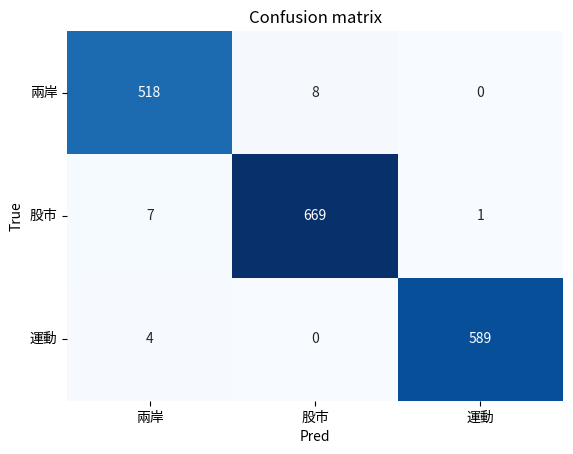

In [27]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

In [28]:
# one-hot encoding
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
print(y_onehot_test.shape)  # (n_samples, n_classes)
y_onehot_test[0,:]

(1796, 3)


array([1, 0, 0])

In [29]:
y_test.iloc[0]

'兩岸'

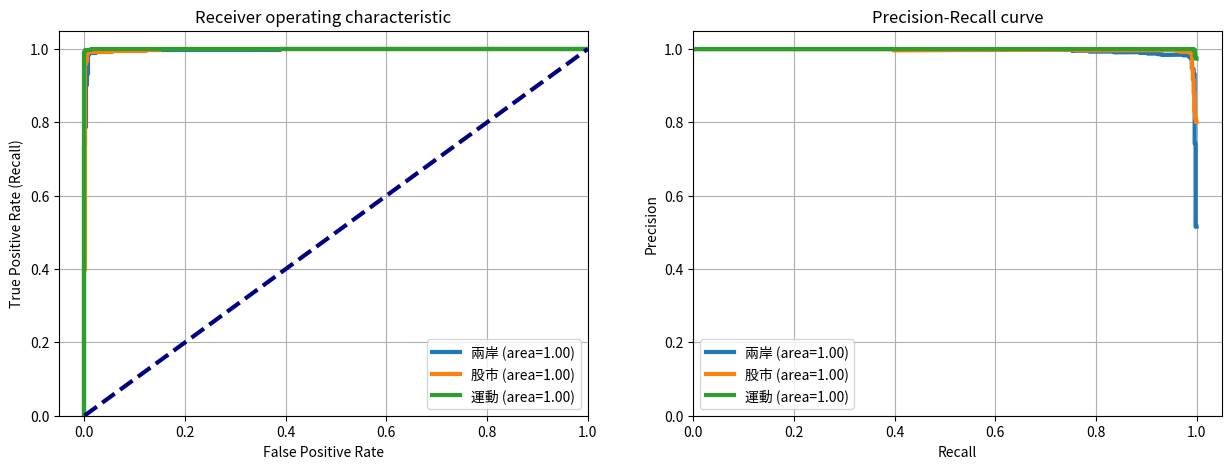

In [30]:
# plot ROC curve and precision-recall curve
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
    ax[0].plot(
        fpr, tpr, lw=3, label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr))
    )
ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
ax[0].set(
    xlim=[-0.05, 1.0],
    ylim=[0.0, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate (Recall)",
    title="Receiver operating characteristic",
)
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
        y_onehot_test[:, i], y_pred_proba[:, i]
    )
    ax[1].plot(
        recall,
        precision,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
    )
ax[1].set(
    xlim=[0.0, 1.05],
    ylim=[0.0, 1.05],
    xlabel="Recall",
    ylabel="Precision",
    title="Precision-Recall curve",
)
ax[1].legend(loc="best")
ax[1].grid(True)

plt.show()


### 3.4 tfidf

改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [31]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16208138, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [32]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          兩岸       0.98      0.98      0.98       526
          股市       0.98      0.99      0.99       677
          運動       1.00      0.99      0.99       593

    accuracy                           0.99      1796
   macro avg       0.99      0.99      0.99      1796
weighted avg       0.99      0.99      0.99      1796



效果一樣也是不錯，可能因為三格新聞版別本來就有很大的差異，用字遣詞會不同。

### 3.5 CV

接著介紹 cross-validation。CV 在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。

* figure1: 

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png"  width="1000">

* figure 2:  

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

source: <https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection>

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

In [33]:
clf = LogisticRegression()
vec_train = CountVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.28493404, 0.27723384, 0.24393272, 0.20816469, 0.17127919]),
 'score_time': array([0.01754975, 0.01569867, 0.01253343, 0.01066828, 0.00988483]),
 'test_f1_macro': array([0.98660048, 0.9757206 , 0.98282789, 0.98672167, 0.98779305]),
 'test_precision_macro': array([0.98700658, 0.97569172, 0.98230507, 0.98670906, 0.98871405]),
 'test_recall_macro': array([0.9862341 , 0.97583175, 0.98348965, 0.98674698, 0.98703223])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [34]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          兩岸       0.97      0.98      0.98      1239
          股市       0.98      0.99      0.98      1534
          運動       1.00      0.99      0.99      1416

    accuracy                           0.98      4189
   macro avg       0.98      0.98      0.98      4189
weighted avg       0.98      0.98      0.98      4189



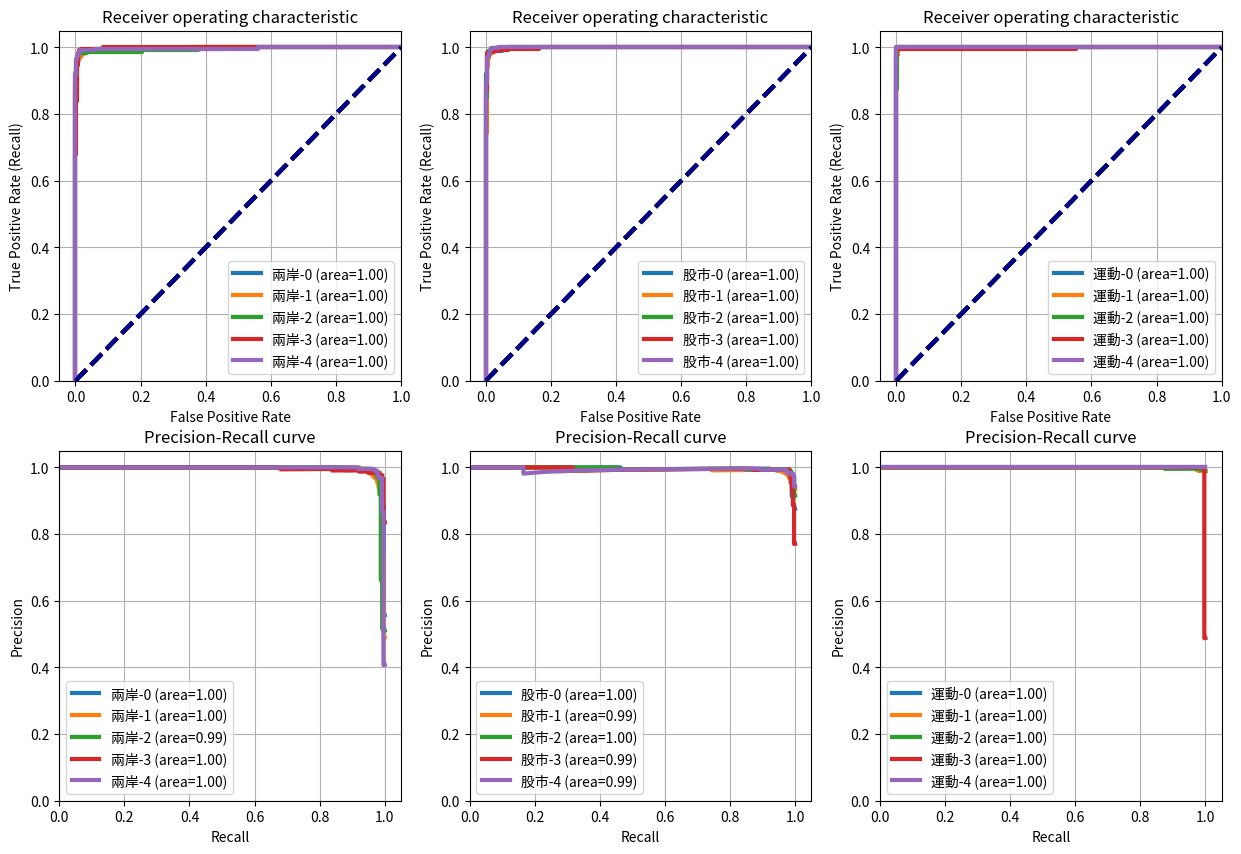

In [35]:
## 將三個新聞類別的 ROC curve 分別畫出來，並在同一張圖上比較不同 fold 的結果
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
kf = KFold(n_splits=5)
classes = scores['estimator'][0].classes_

for k, (train, test) in enumerate(kf.split(vec_train, y_train)):
    clf.fit(vec_train[train,:], y_train.iloc[train])
    y_pred = clf.predict(vec_train[test,:])    
    y_test = y_train.iloc[test]
    y_pred_proba = clf.predict_proba(vec_train[test,:])
    y_onehot_test = label_binarizer.transform(y_test)        
    

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
        ax[0,i].plot(
            fpr,
            tpr,
            lw=3,
            label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
        )
        ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
        ax[0,i].set(
            xlim=[-0.05, 1.0],
            ylim=[0.0, 1.05],
            xlabel="False Positive Rate",
            ylabel="True Positive Rate (Recall)",
            title="Receiver operating characteristic",
        )
        ax[0,i].legend(loc="best")
        ax[0,i].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(
            y_onehot_test[:, i], y_pred_proba[:, i]
        )
        ax[1,i].plot(
            recall,
            precision,
            lw=3,
            label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
        )
        ax[1,i].set(
            xlim=[0.0, 1.05],
            ylim=[0.0, 1.05],
            xlabel="Recall",
            ylabel="Precision",
            title="Precision-Recall curve",
        )
        ax[1,i].legend(loc="best")
        ax[1,i].grid(True)

plt.show()

## 4. 比較不同模型效果

In [36]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)


    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    kf = KFold(n_splits=5)
    
    for k, (train, test) in enumerate(kf.split(vec_X, y)):
        clf.fit(vec_X[train,:], y.iloc[train])
        y_pred = clf.predict(vec_X[test,:])    
        y_test = y.iloc[test]
        y_pred_proba = clf.predict_proba(vec_X[test,:])
        y_onehot_test = label_binarizer.transform(y_test)        
        
    
        ## Plot roc
        for i in range(len(classes)):
            fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
            ax[0,i].plot(
                fpr,
                tpr,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
            )
            ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
            ax[0,i].set(
                xlim=[-0.05, 1.0],
                ylim=[0.0, 1.05],
                xlabel="False Positive Rate",
                ylabel="True Positive Rate (Recall)",
                title="Receiver operating characteristic",
            )
            ax[0,i].legend(loc="best")
            ax[0,i].grid(True)

        ## Plot precision-recall curve
        for i in range(len(classes)):
            precision, recall, thresholds = precision_recall_curve(
                y_onehot_test[:, i], y_pred_proba[:, i]
            )
            ax[1,i].plot(
                recall,
                precision,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
            )
            ax[1,i].set(
                xlim=[0.0, 1.05],
                ylim=[0.0, 1.05],
                xlabel="Recall",
                ylabel="Precision",
                title="Precision-Recall curve",
            )
            ax[1,i].legend(loc="best")
            ax[1,i].grid(True)

    plt.show()

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

          兩岸       0.97      0.98      0.98      1239
          股市       0.98      0.99      0.98      1534
          運動       1.00      0.99      0.99      1416

    accuracy                           0.98      4189
   macro avg       0.98      0.98      0.98      4189
weighted avg       0.98      0.98      0.98      4189



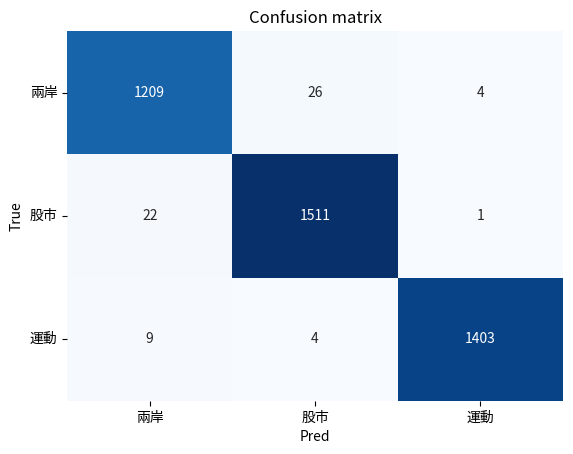

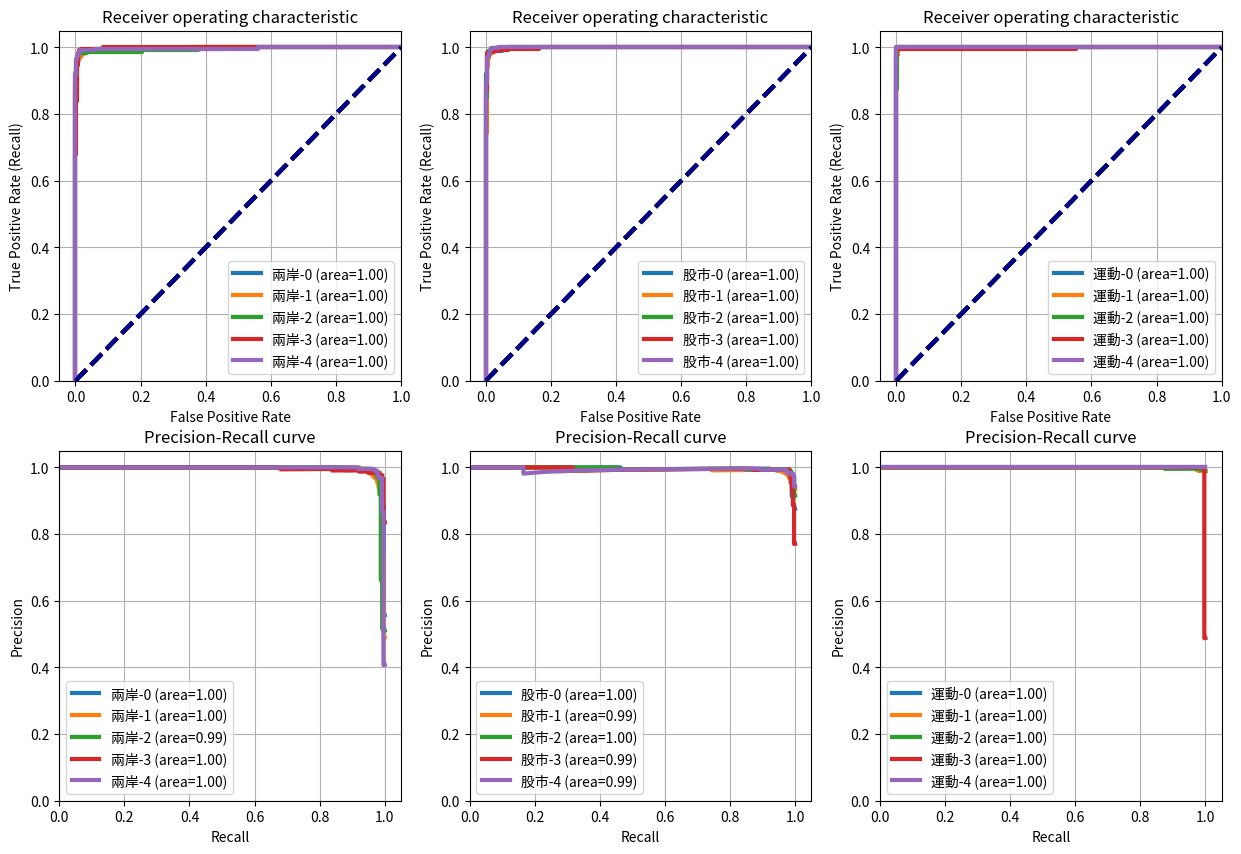

In [37]:
vectorizer = CountVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

          兩岸       0.97      0.98      0.98      1239
          股市       0.98      0.99      0.98      1534
          運動       1.00      0.99      0.99      1416

    accuracy                           0.98      4189
   macro avg       0.98      0.98      0.98      4189
weighted avg       0.98      0.98      0.98      4189



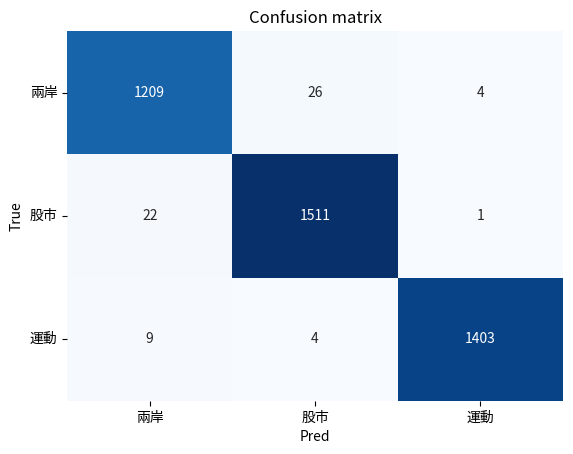

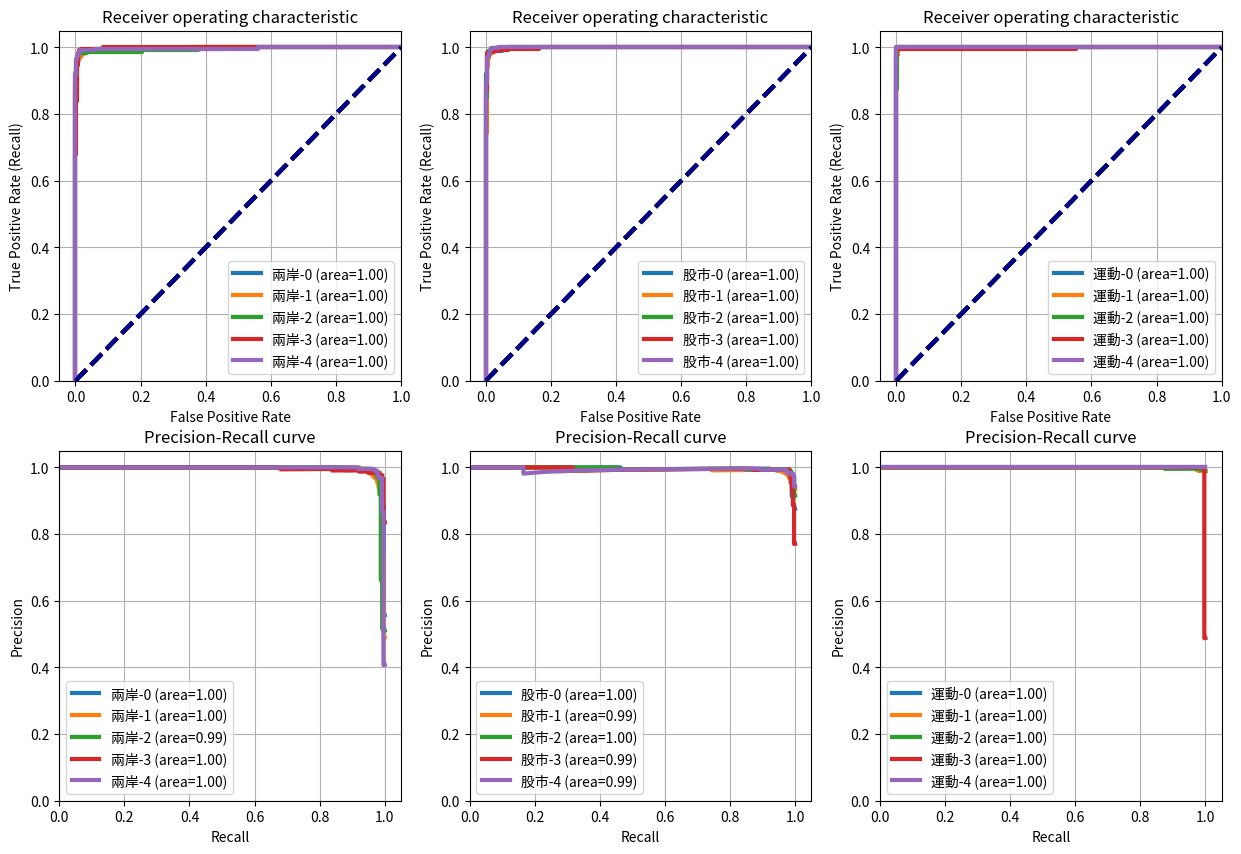

now training: clf_dtree
              precision    recall  f1-score   support

          兩岸       0.93      0.93      0.93      1239
          股市       0.94      0.95      0.94      1534
          運動       0.99      0.98      0.98      1416

    accuracy                           0.95      4189
   macro avg       0.95      0.95      0.95      4189
weighted avg       0.95      0.95      0.95      4189



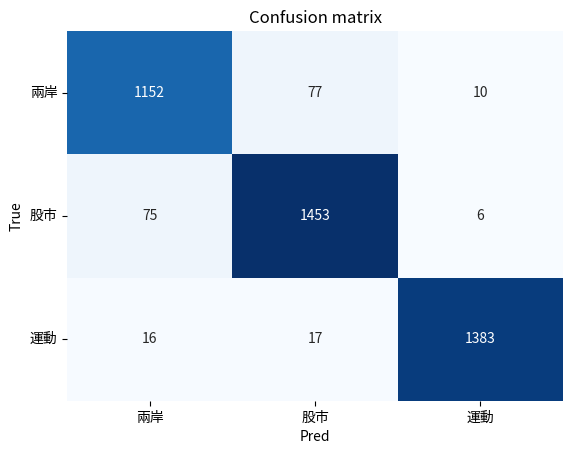

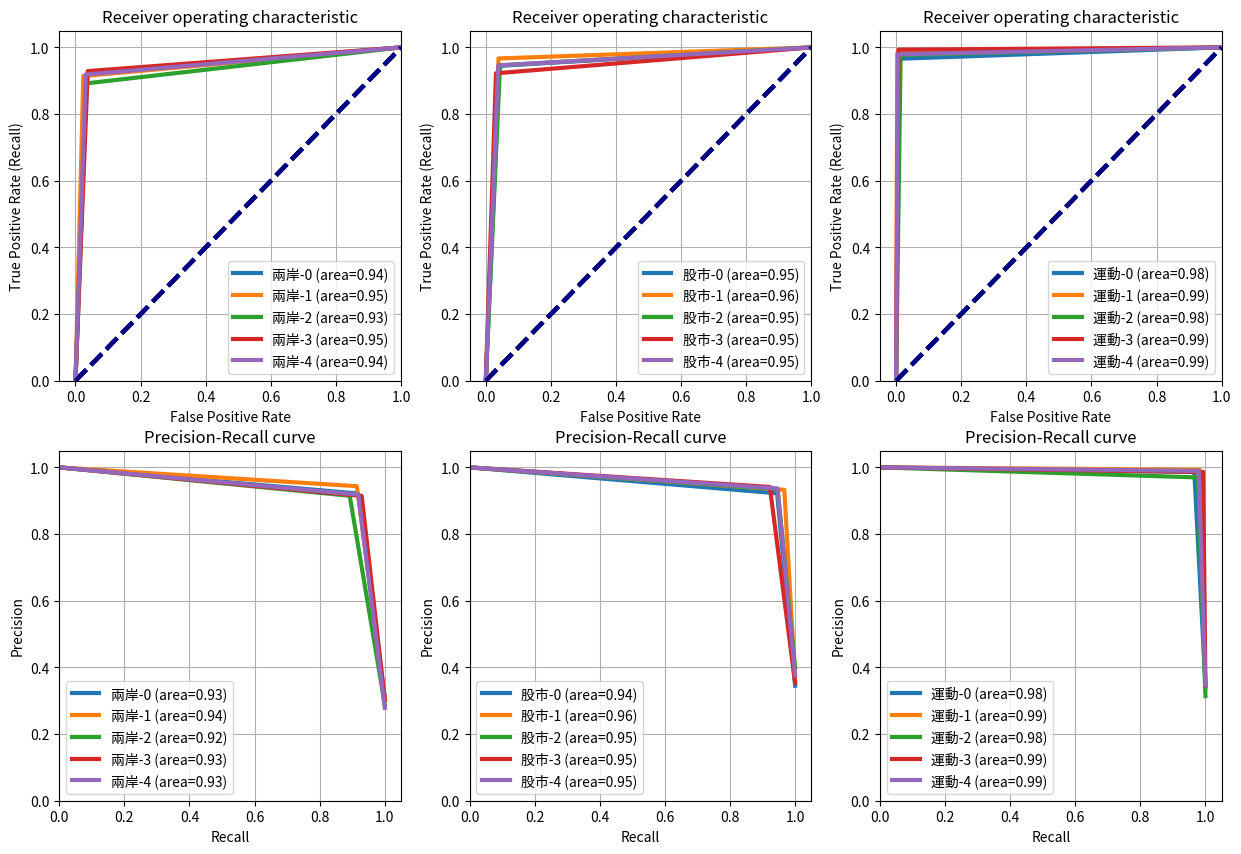

In [38]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
# model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
vectorizer = CountVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


In [39]:
result_set['clf_logistic']

{'兩岸': {'precision': 0.975,
  'recall': 0.9757869249394673,
  'f1-score': 0.9753933037515127,
  'support': 1239},
 '股市': {'precision': 0.9805321219987021,
  'recall': 0.9850065189048239,
  'f1-score': 0.9827642276422763,
  'support': 1534},
 '運動': {'precision': 0.9964488636363636,
  'recall': 0.990819209039548,
  'f1-score': 0.9936260623229461,
  'support': 1416},
 'accuracy': 0.9842444497493436,
 'macro avg': {'precision': 0.9839936618783552,
  'recall': 0.9838708842946131,
  'f1-score': 0.983927864572245,
  'support': 4189},
 'weighted avg': {'precision': 0.9842761675949152,
  'recall': 0.9842444497493436,
  'f1-score': 0.984255701313122,
  'support': 4189}}

In [40]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['macro avg'][best_model_metric] > max:
        max = v['macro avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_logistic
{'accuracy': 0.9842444497493436,
 'macro avg': {'f1-score': 0.983927864572245,
               'precision': 0.9839936618783552,
               'recall': 0.9838708842946131,
               'support': 4189},
 'weighted avg': {'f1-score': 0.984255701313122,
                  'precision': 0.9842761675949152,
                  'recall': 0.9842444497493436,
                  'support': 4189},
 '兩岸': {'f1-score': 0.9753933037515127,
        'precision': 0.975,
        'recall': 0.9757869249394673,
        'support': 1239},
 '股市': {'f1-score': 0.9827642276422763,
        'precision': 0.9805321219987021,
        'recall': 0.9850065189048239,
        'support': 1534},
 '運動': {'f1-score': 0.9936260623229461,
        'precision': 0.9964488636363636,
        'recall': 0.990819209039548,
        'support': 1416}}


In [41]:
y_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          兩岸       0.98      0.98      0.98       526
          股市       0.99      0.99      0.99       677
          運動       1.00      0.99      1.00       593

    accuracy                           0.99      1796
   macro avg       0.99      0.99      0.99      1796
weighted avg       0.99      0.99      0.99      1796



In [42]:
model_set['clf_logistic'].predict(vectorizer.transform(["市場 將 迎來 許多 大企業 的 財報 美國 股市 主要指數 今天 早盤 小幅震盪"]))

array(['股市'], dtype=object)

* logistic 的模型表現比決策樹的略好一點。
* 另外也可以嘗試用 tfidf 作為 `vectorizer`，比較看看相較直接的詞頻表，是否效果更好。
* 當 label 的類別不平衡的時候，會需要用其他手法或更複雜的模型，來解決資料類別不平衡的問題

## 5 分析可解釋模型的結果

### 5.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate 代表特徵每增加一單位（在此處會是該文章的某字詞頻 +1），y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉logistic regression + cv tokenizer 為例

In [43]:
model_set[best_model_name]

LogisticRegression()

In [44]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("Word Frequency", size=14)

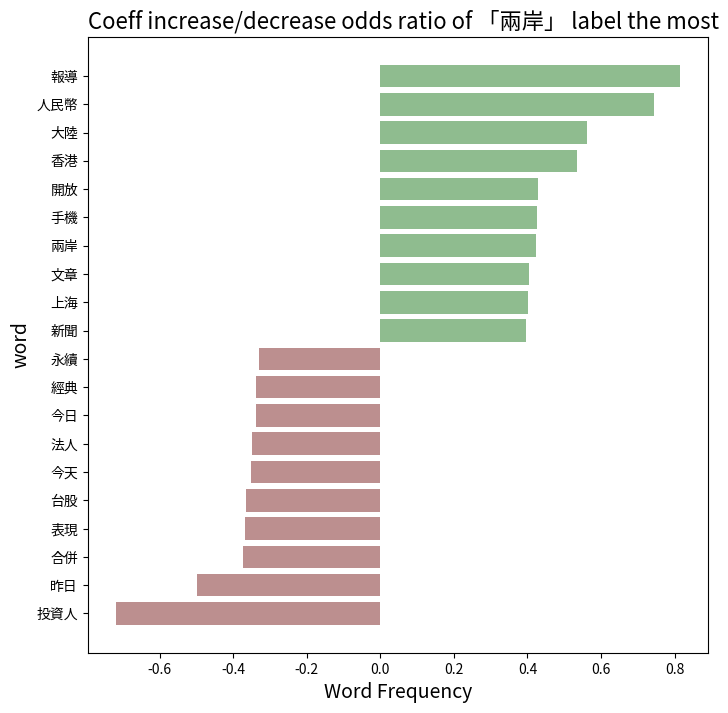

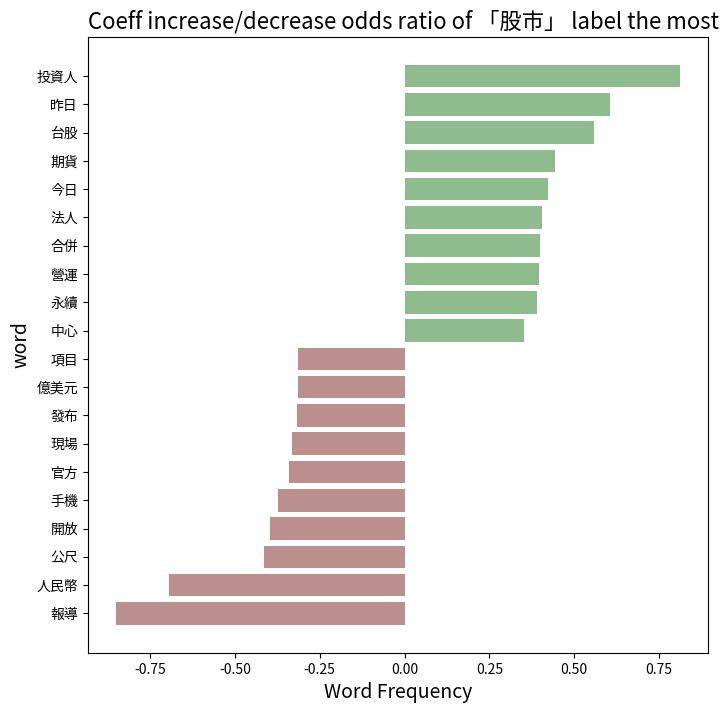

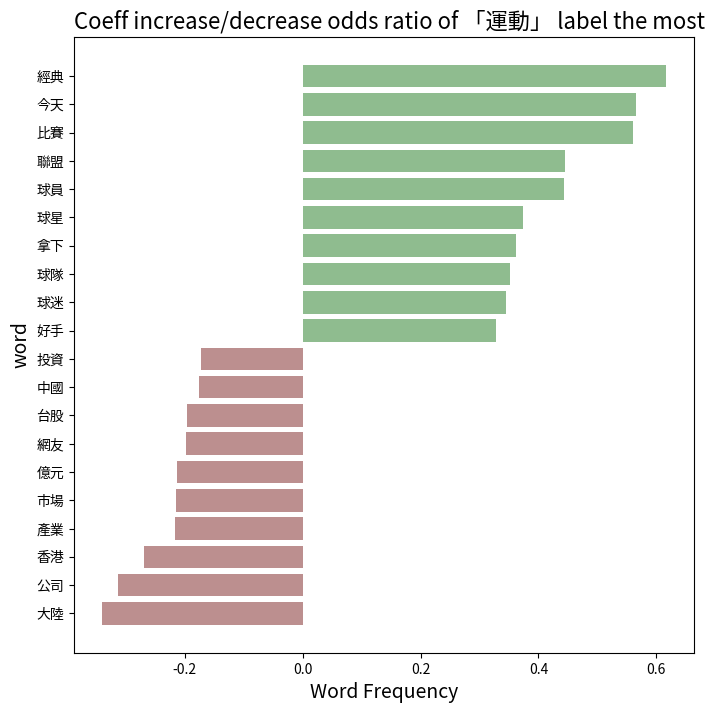

In [45]:
plot_coef(logistic_reg_model=model_set[best_model_name], feature_names=vectorizer.get_feature_names(), top_n=10)

「兩岸」中高係數的字多半與中國有關；「股市」則是投資、金融市場相關的字；而因為三月剛好是經典賽期間，「運動」中影響最大的字是經典。

### 預測新聞類別

In [46]:
ct = pd.read_csv("./raw_data/ct_news_04.csv")
ct = ct.groupby("artCatagory").head(3)
ct

,system_id,artUrl,artCatagory,artTitle,artDate,artContent,dataSource
0,1,https://www.chinatimes.com/newspapers/20230401...,政治,外媒爆 蔡總統雷根圖書館演說恐生變,2023-04-01 04:10:00,蔡英文總統出訪中美洲友邦途中過境美國，美東時間3月30日晚間，在紐約受邀出席美國「哈德遜研究...,chinatimes
1,2,https://www.chinatimes.com/newspapers/20230401...,政治,挺侯聯盟第1波 10藍委籲黨中央速徵召,2023-04-01 04:10:00,國民黨2024總統大選將以徵召方式決定人選，黨中央雖已積極展開徵詢，但目前黨內最強母雞就是新...,chinatimes
2,3,https://www.chinatimes.com/newspapers/20230401...,政治,徐弘庭斥黨員投票水很深 宣布退選,2023-04-01 04:10:00,國民黨立委初選內鬥不斷，台北市第8選區（中正、文山）初選方式採37制，原本有意投入初選的北市...,chinatimes
71,152,https://www.chinatimes.com/newspapers/20230401...,財經,16檔WIN贏家概念股 出列,2023-04-01 04:10:00,美國銀行業危機緩和，市場押注聯準會將在5月最後升息，激勵資金回籠股市。上市櫃公司陸續公布財報...,chinatimes
72,153,https://www.chinatimes.com/newspapers/20230401...,財經,上市櫃去年獲利 跌破4兆元,2023-04-01 04:10:00,疫情紅利消退、金融業防疫保單及債券評價減損等衝擊，台股上市櫃公司2022年獲利跌破4兆至3....,chinatimes
73,154,https://www.chinatimes.com/newspapers/20230401...,財經,跟隨美國腳步，劍指中國 日本限制23項半導體設備出口,2023-04-01 04:10:00,日本經濟產業大臣西村康稔在新聞稿中指出，日本將對用來製造晶片的6類設備實施出口管制，當中包括...,chinatimes
214,295,https://www.chinatimes.com/newspapers/20230401...,兩岸,馬英九搭高鐵返湘潭祭祖 宋濤一路相陪,2023-04-01 04:10:00,前總統馬英九的訪陸之行今天將進入重頭戲，由大陸國台辦主任宋濤陪同，和4名姐妹一起回到湖南湘潭...,chinatimes
215,296,https://www.chinatimes.com/newspapers/20230401...,兩岸,英獲准加入CPTPP 兩岸誰先入會受關注,2023-04-01 04:10:00,英國首相蘇納克3月31日宣布，英國已完成相關談判並達成協議，將加入《跨太平洋夥伴全面進步協定...,chinatimes
216,297,https://www.chinatimes.com/newspapers/20230401...,兩岸,普丁再簽徵兵令 保證不送烏克蘭戰場,2023-04-01 04:10:00,俄國總統普丁3月30日簽署例行春季徵兵令，將自4月1日至7月15日招募14.7萬名18至27...,chinatimes
249,330,https://www.chinatimes.com/newspapers/20230401...,體育,中職34年 點燃戰火 象猿拚 開門紅,2023-04-01 04:10:00,中華職棒34年球季今天在洲際棒球場點燃戰火，本報評選出五大亮點，而開幕戰由去年「台灣大戰」對...,chinatimes


In [47]:
# 移除網址格式
ct["artContent"] = ct.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
ct["artTitle"] = ct["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
ct["artContent"] = ct.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
ct["artTitle"] = ct["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,外媒爆蔡總統雷根圖書館演說恐生變蔡英文總統出訪中美洲友邦途中過境美國美東時間月日晚間在紐約受...,https://www.chinatimes.com/newspapers/20230401...,政治,外媒爆 總統 雷根 圖書館 演說 生變 英文 總統 出訪 中美洲 友邦 途中 過境 美國 美...
1,挺侯聯盟第波藍委籲黨中央速徵召國民黨總統大選將以徵召方式決定人選黨中央雖已積極展開徵詢但目前...,https://www.chinatimes.com/newspapers/20230401...,政治,挺侯 聯盟 第波 藍委籲 黨中央 徵召 國民黨 總統大選 將以 徵召 方式 決定 人選 黨中...
2,徐弘庭斥黨員投票水很深宣布退選國民黨立委初選內鬥不斷台北市第選區中正文山初選方式採制原本有意...,https://www.chinatimes.com/newspapers/20230401...,政治,徐弘庭斥 黨員 投票 宣布 退選 國民黨 立委 初選 不斷 台北市 選區 正文 初選 方式 ...
71,檔贏家概念股出列美國銀行業危機緩和市場押注聯準會將在月最後升息激勵資金回籠股市上市櫃公司陸續...,https://www.chinatimes.com/newspapers/20230401...,財經,贏家 概念股 出列 美國 銀行業 危機 緩和 市場 押注 聯準 會將 最後 升息 激勵 資金...
72,上市櫃去年獲利跌破兆元疫情紅利消退金融業防疫保單及債券評價減損等衝擊台股上市櫃公司年獲利跌破...,https://www.chinatimes.com/newspapers/20230401...,財經,上市 去年 獲利 跌破 兆元 疫情 紅利 消退 金融業 防疫 保單 債券 評價 減損 衝擊 ...


In [48]:
ct['artCatagory'].value_counts()

政治    3
財經    3
兩岸    3
體育    3
Name: artCatagory, dtype: int64

In [49]:
X = ct['words']
y_pred = model_set[best_model_name].predict(vectorizer.transform(X))
ct['pred'] = y_pred

In [50]:
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,外媒爆 總統 雷根 圖書館 演說 生變 英文 總統 出訪 中美洲 友邦 途中 過境 美國 美...,政治,兩岸
1,挺侯 聯盟 第波 藍委籲 黨中央 徵召 國民黨 總統大選 將以 徵召 方式 決定 人選 黨中...,政治,兩岸
2,徐弘庭斥 黨員 投票 宣布 退選 國民黨 立委 初選 不斷 台北市 選區 正文 初選 方式 ...,政治,股市
71,贏家 概念股 出列 美國 銀行業 危機 緩和 市場 押注 聯準 會將 最後 升息 激勵 資金...,財經,股市
72,上市 去年 獲利 跌破 兆元 疫情 紅利 消退 金融業 防疫 保單 債券 評價 減損 衝擊 ...,財經,股市
73,跟隨 美國 腳步 中國 日本 限制 半導體 設備 出口 日本 經濟 產業 大臣 西村 康稔 ...,財經,兩岸
214,馬英九 高鐵 湘潭 祭祖 宋濤 一路 相陪 總統 馬英九 訪陸 之行 天將 進入 重頭戲 大...,兩岸,兩岸
215,獲准 加入 兩岸 入會 關注 英國首相 納克 宣布 英國 完成 相關 談判 達成協議 加入 ...,兩岸,兩岸
216,普丁 再簽 徵兵 保證 不送 烏克蘭 戰場 俄國 總統 普丁 簽署 例行 春季 徵兵 令將 ...,兩岸,兩岸
249,中職 點燃 戰火 象猿 開門紅 中華 職棒 球季 今天 洲際 棒球場 點燃 戰火 本報 評選...,體育,運動


In [51]:
ct['words'][73]

'跟隨 美國 腳步 中國 日本 限制 半導體 設備 出口 日本 經濟 產業 大臣 西村 康稔 新聞稿 指出 日本 將對 用來 製造 晶片 的類 設備 實施 出口 管制 包括 清潔 沉積 微影 蝕刻 西村 康稔 強調 措施 旨在 防止 構成 軍事 威脅 國家 獲得 日本 先進 技術 針對 特定 國家 日本 做出 宣布 時機 恰巧是 美國 去年 晶片 製造 工具 出口 中國 實施 全面 限制 之後 當時 美方 理由 擔心 北京 將用 先進 半導體 強化 軍事力量 美國 想要 削減 中國 軍事 能力 仍須 日本 荷蘭 加入 發揮 效果 美日 當今 全球 前三大 半導體 設備 生產國 出口 限制 措施 受到 波及 日本 業者 十多家 像是 尼康 東京 威力 科創 愛德 測試 日本 過去 晶片 製造 主導地位 全球 市占率 節節敗退 下滑 僅剩 日本 依舊 晶片 製造 設備 半導體 材料 供應 大國 東京 威力 科創 生產 晶片 製造 工具 全球 兩成 信越 化學工業 勝高則 矽晶圓 製造 大廠 了解 日荷 兩國 今年 美國 達成 共識 限制 小於 奈米 製程 晶片 製造 設備 出口 中國 避免 激怒 中國 並未 宣布 這項 決定 日本 公開 承認 達成 這項 協議'

模型對另一個新聞網的預測結果大致上還算不錯，其中預測錯的這篇，也算與國際地緣政治相關的財經新聞。

* accuracy可能會因為資料分布不同而有所偏差，所以評估模型的時候，可以加入一起 F1-score, recall, precision, AUC 等常見分類任務指標來評估。
* 在這裡可以看到個不同模型的 F1-score 都不會差到太多，代表就算只用 1000 維的 DTM 來代表一篇文章，其實也是有一定程度地的預測能力。

## 教學目標
1. 能夠利用 DTM 將文章表示成一串數字，以利後續的分析或預測任務使用
2. 能夠使用機器學習流程，訓練一個文集分類模型
    * 額外提問：只要能夠把文字資料轉換成 `input` 與 `label` 的形式，就能夠來訓練預測模型。，例如本週就是將新聞轉成數字 input，label 為新聞類別。文字分析中有哪些可能的應用場景？
        * 用企業的財報預測企業股價/ROA?
        * 用總統候選人的選前演講稿預測得票率？
3. 能夠解釋在可解釋模型中，詞頻/tfidf 作為 input feature 的意義

## 附錄

In [52]:
# 定義模型訓練組合
## 不做 cross validation, 用 test data 來評估模型的版本
## pipeline: 資料處理 vectorizer + 分類器
def train(vectorizer, clf, X_train, y_train, X_test, y_test):

    ## train classifier
    vec_train = vectorizer.fit_transform(X_train).toarray()
    vec_test = vectorizer.transform(X_test).toarray()
    clf.fit(vec_train, y_train)
    

    ## test classifier
    y_pred = clf.predict(vec_test)
    y_pred_proba = clf.predict_proba(vec_test)

    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    ## Accuracy, Precision, Recall, F1-score
    print(classification_report(y_test, y_pred))

    classes = clf.classes_
    ## Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
        ax[0].plot(
            fpr,
            tpr,
            lw=3,
            label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr)),
        )
    ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
    ax[0].set(
        xlim=[-0.05, 1.0],
        ylim=[0.0, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate (Recall)",
        title="Receiver operating characteristic",
    )
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(
            y_onehot_test[:, i], y_pred_proba[:, i]
        )
        ax[1].plot(
            recall,
            precision,
            lw=3,
            label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
        )
    ax[1].set(
        xlim=[0.0, 1.05],
        ylim=[0.0, 1.05],
        xlabel="Recall",
        ylabel="Precision",
        title="Precision-Recall curve",
    )
    ax[1].legend(loc="best")
    ax[1].grid(True)

    plt.show()

    # return the model object
    return classification_report(y_test, y_pred, output_dict=True)


              precision    recall  f1-score   support

          兩岸       0.98      0.98      0.98       526
          股市       0.99      0.99      0.99       677
          運動       1.00      0.99      1.00       593

    accuracy                           0.99      1796
   macro avg       0.99      0.99      0.99      1796
weighted avg       0.99      0.99      0.99      1796



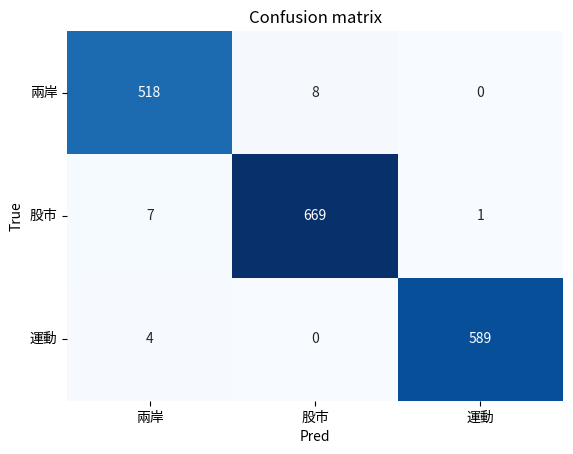

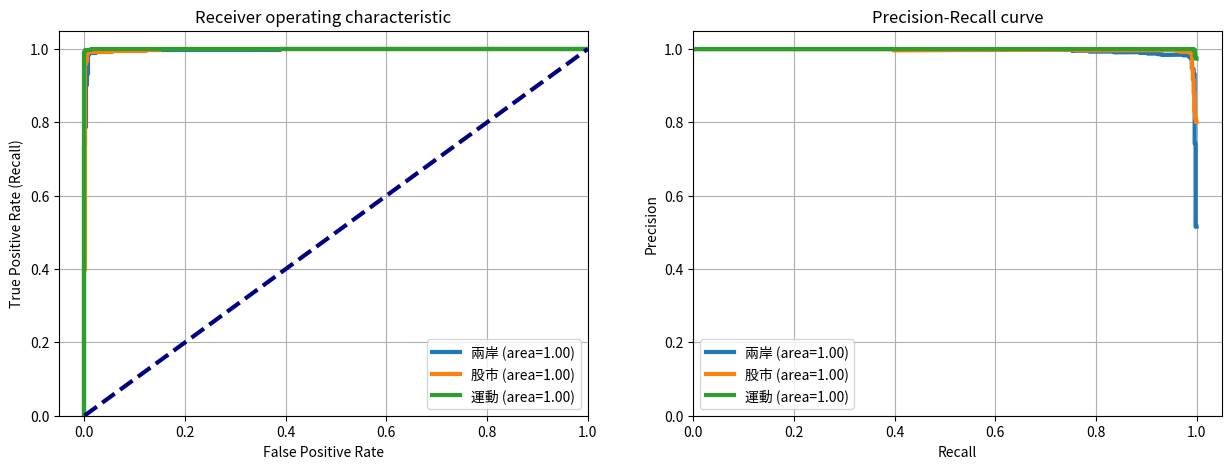

{'兩岸': {'precision': 0.9792060491493384,
  'recall': 0.9847908745247148,
  'f1-score': 0.9819905213270143,
  'support': 526},
 '股市': {'precision': 0.9881831610044313,
  'recall': 0.9881831610044313,
  'f1-score': 0.9881831610044313,
  'support': 677},
 '運動': {'precision': 0.9983050847457627,
  'recall': 0.9932546374367622,
  'f1-score': 0.9957734573119189,
  'support': 593},
 'accuracy': 0.9888641425389755,
 'macro avg': {'precision': 0.9885647649665108,
  'recall': 0.9887428909886361,
  'f1-score': 0.9886490465477881,
  'support': 1796},
 'weighted avg': {'precision': 0.9888960451596821,
  'recall': 0.9888641425389755,
  'f1-score': 0.9888756538997647,
  'support': 1796}}

In [53]:
data = udn
X = data["words"]
y = data["artCatagory"]
# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
vectorizer = CountVectorizer(max_features=1000)
clf = LogisticRegression()
train(vectorizer, clf, X_train, y_train, X_test, y_test)

    畫出決策樹的 code

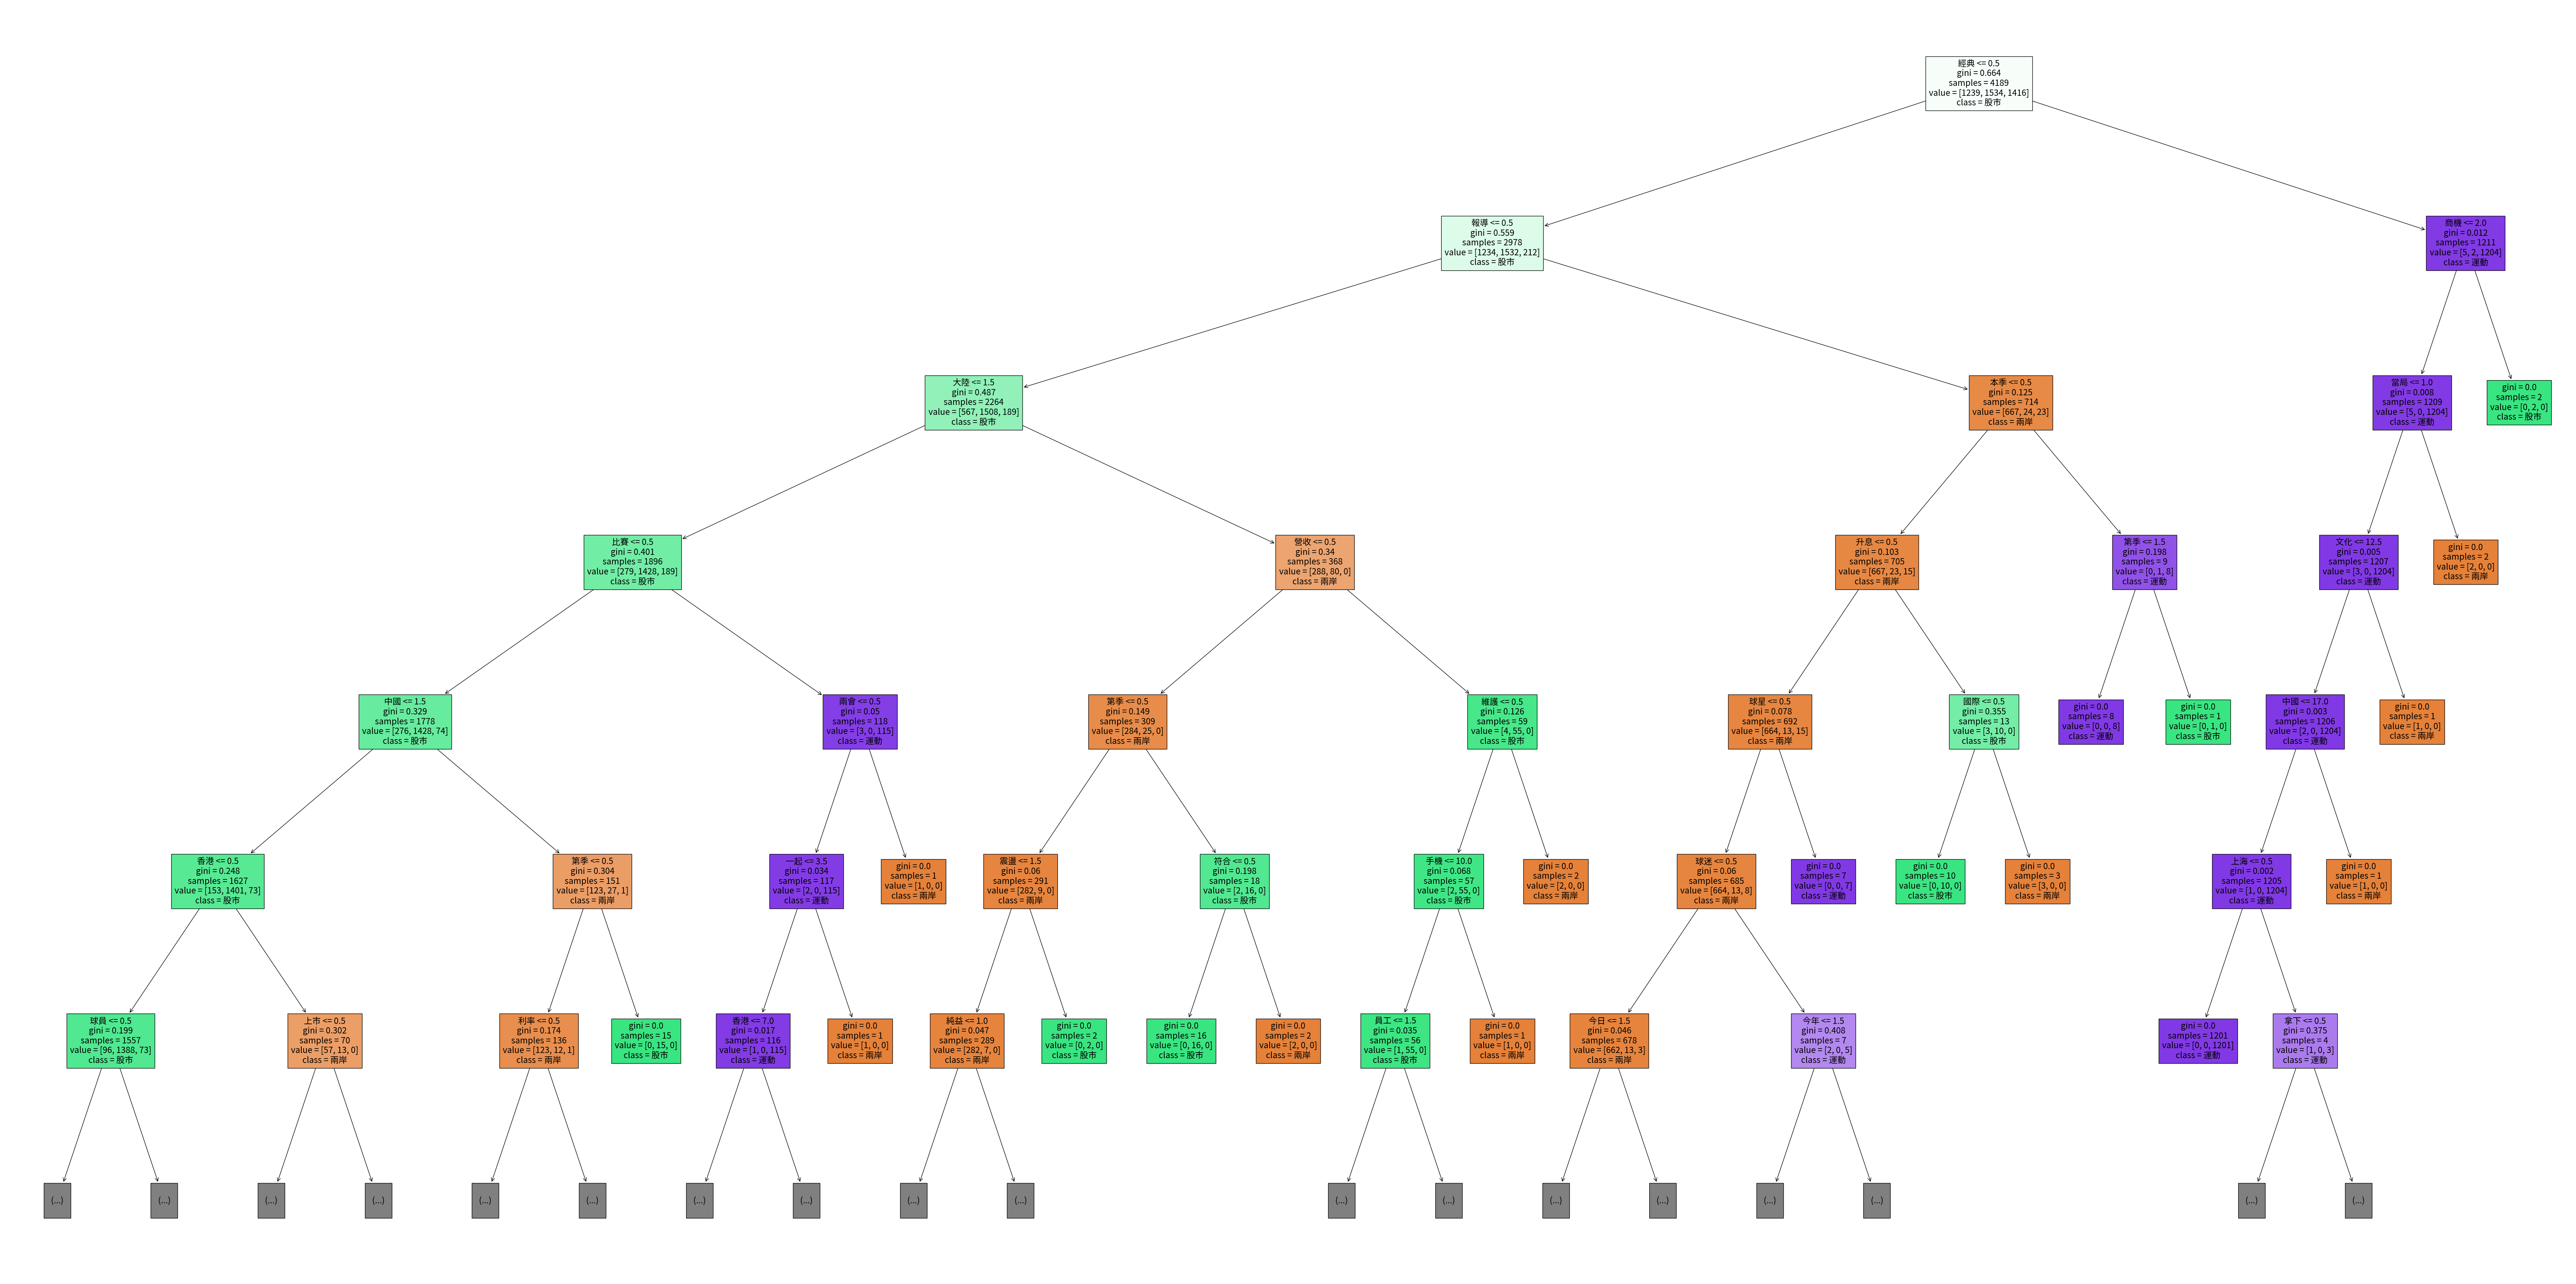

In [54]:
fig = plt.figure()
fig.set_size_inches(90, 45)
plot_tree(
    model_set["clf_dtree"], 
    max_depth=6, # 最大深度
    feature_names=vectorizer.get_feature_names(), 
    class_names=model_set["clf_dtree"].classes_,
    filled=True
)
fig.savefig("decistion_tree.png")